# Object Detection With Google CoLab free GPU

      Currently, I am working on a fun application which combines Artificial Intelligence and Augmented Reality. An important feature of this application is being able to detect physical objects in the real world. As we know occlusion is a hard task in Augmented Reality, it’s solvable by Deep Learning.

      Google Recently open sourced their GPU for public. Things never become better than this. Anyone who is interested in deep learning might give it a shot. With Tesla K80 (technical details here), I had my training done in less than 1 hour! Since most of the information found online haven’t provided a thorough walk-through of applying this powerful free GPU, I am writing this small article to present my process of customized object detection training in hope that it will save people’s time of exploration.
      
      Our detection target is my little mascot, let's call it Joyful Ducky Buddy. 

<a href="http://www.youtube.com/watch?feature=player_embedded&v=CkPXzrOY3vs
" target="_blank"><img src="http://img.youtube.com/vi/CkPXzrOY3vs/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="240" height="180" border="10" /></a>

## Step 1. Reset The Virtual Machine

In [0]:
!kill -9 -1 # reset virtual machine

In [1]:
# '/device:GPU:0' indicates that the virtual machine is powered up with GPU. 
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Step 2. Set Up Tensorflow Model Training Environment

In [0]:
# download tensorflow object detection models from github 
# Environment installation on your local machine can be found here: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md
!git clone https://github.com/tensorflow/models.git

# Protobuf Compilation
!apt-get -qq install libprotobuf-java protobuf-compiler
import os
os.chdir('models/research')
!protoc object_detection/protos/*.proto --python_out=.

# Add Libraries to PYTHONPATH. This is different from local machine: export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
# I haven't found a way to set env virables on CoLab VM, yet the following method works instead!
import sys
sys.path.append('/content/models/research/slim')

In [5]:
# Test if Tensorflow environment and pythonpath is set.
%run object_detection/legacy/trainer_test.py

/content/models/research


## Step 3. Upload Image Dataset and Configuration Files
1. Create a google drive folder . In this tutorial, we use **DuckyBuddy** as our working directory.
2. Label dataset images and upload the images with their xml files to DuckyBuddy. 
3. Create folders: data and training. Data contains ducky_buddy.pbtxt file
4. Training folder contains label files and TFRecords
5. Authorize access of DuckyBuddy folder to Virtual Machine

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [7]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/DuckyBuddy/
!ls drive/DuckyBuddy/data
!ls drive/DuckyBuddy/training

data  DuckyBuddyDetector.ipynb	generate_tfrecord.py  images  training
ducky_buddy.pbtxt
ssd_mobilenet_v2_coco.config  test_labels.csv  train_labels.csv


## Step 4. Migrate Data to Virtual Machine from Google Drive

1. Import relevant models in order to do TFRcord generation
2. Compile del_all_flags function for later usage.

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

In [0]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:    
      FLAGS.__delattr__(keys)

In [10]:
# dataset copied to virtual machine

!cp -r drive/DuckyBuddy/images/ object_detection/images/
!rsync -avhu --progress drive/DuckyBuddy/data/ object_detection/data/
!rsync -avhu --progress drive/DuckyBuddy/training/ object_detection/training/
!cp drive/DuckyBuddy/generate_tfrecord.py object_detection/
os.chdir('object_detection')

sending incremental file list
./
ducky_buddy.pbtxt
             44 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=0/2)

sent 158 bytes  received 38 bytes  392.00 bytes/sec
total size is 44  speedup is 0.22
sending incremental file list
created directory object_detection/training
./
ssd_mobilenet_v2_coco.config
          4.31K 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=2/4)
test_labels.csv
            523 100%    0.84kB/s    0:00:00 (xfr#2, to-chk=1/4)
train_labels.csv
          4.40K 100%    3.38kB/s    0:00:01 (xfr#3, to-chk=0/4)

sent 9.49K bytes  received 124 bytes  3.85K bytes/sec
total size is 9.23K  speedup is 0.96


In [16]:
# generate TFRecord for model training
del_all_flags(tf.flags.FLAGS)
%run generate_tfrecord.py --csv_input=training/train_labels.csv --output_path=training/train.record
del_all_flags(tf.flags.FLAGS)
%run generate_tfrecord.py --csv_input=training/test_labels.csv --output_path=training/test.record
!ls -l training


Successfully created the TFRecords: /content/models/research/object_detection/training/test.record
total 9072
-rw-r--r-- 1 root root    4312 Aug  9 20:42 ssd_mobilenet_v2_coco.config
-rw-r--r-- 1 root root     523 Aug  9 20:18 test_labels.csv
-rw-r--r-- 1 root root 1169958 Aug  9 22:33 test.record
-rw-r--r-- 1 root root    4399 Aug  9 20:18 train_labels.csv
-rw-r--r-- 1 root root 8096334 Aug  9 22:28 train.record


## Step 5. Start Training DuckyBuddy Detection Model

1. Download the state of art MobileNet V2
2. Train the model

In [0]:


MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'victory_statues_map.pbtxt')


opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  tar_file.extract(file, os.getcwd())
    

In [0]:
# Run the training until we get a loss which is statically close to 1 or less than 1.

del_all_flags(tf.flags.FLAGS)
%run legacy/train.py \
--logtostderr \
--pipeline_config_path=training/ssd_mobilenet_v2_coco.config \
--train_dir=training

# !cp ../drive/DuckyBuddy/training/ssd_mobilenet_v2_coco.config training/ssd_mobilenet_v2_coco.config
# !ls training

## Step 6. Generate DuckyBuddy's Inference Graph for Detection

In [24]:
# Check our existing trained model check points. Choose the model with the largest step number. 
!ls -l training

total 450552
-rw-r--r-- 1 root root      268 Aug  9 23:19 checkpoint
-rw-r--r-- 1 root root 26269012 Aug  9 23:21 events.out.tfevents.1533854353.3cc8868027be
-rw-r--r-- 1 root root 14755956 Aug  9 22:39 graph.pbtxt
-rw-r--r-- 1 root root 73926504 Aug  9 22:39 model.ckpt-0.data-00000-of-00001
-rw-r--r-- 1 root root    41797 Aug  9 22:39 model.ckpt-0.index
-rw-r--r-- 1 root root  8232343 Aug  9 22:39 model.ckpt-0.meta
-rw-r--r-- 1 root root 73926504 Aug  9 22:49 model.ckpt-1032.data-00000-of-00001
-rw-r--r-- 1 root root    41797 Aug  9 22:49 model.ckpt-1032.index
-rw-r--r-- 1 root root  8232343 Aug  9 22:49 model.ckpt-1032.meta
-rw-r--r-- 1 root root 73926504 Aug  9 22:59 model.ckpt-2088.data-00000-of-00001
-rw-r--r-- 1 root root    41797 Aug  9 22:59 model.ckpt-2088.index
-rw-r--r-- 1 root root  8232343 Aug  9 22:59 model.ckpt-2088.meta
-rw-r--r-- 1 root root 73926504 Aug  9 23:09 model.ckpt-3147.data-00000-of-00001
-rw-r--r-- 1 root root    41797 Aug  9 23:09 model.ckpt-3147.index
-rw-

In [0]:
# Generate DuckyBuddy Inference Graph
del_all_flags(tf.flags.FLAGS)
%run export_inference_graph.py --input_type image_tensor --pipeline_config_path training/ssd_mobilenet_v2_coco.config --trained_checkpoint_prefix training/model.ckpt-4206 --output_directory ducky_buddy_inference_graph

In [27]:
# show our ducky_buddy detection model. If it contains model.ckpt.index, meta and data, 3 in a set, we can start detection.

!ls ducky_buddy_inference_graph

# Zip and copy trained model to working directory as a backup
!tar -czvf ducky_buddy_detection_model_08092018.tar.gz ducky_buddy_inference_graph
!mv ducky_buddy_detection_model_08092018.tar.gz ../drive/DuckyBuddy/

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config
ducky_buddy_inference_graph/
ducky_buddy_inference_graph/pipeline.config
ducky_buddy_inference_graph/frozen_inference_graph.pb
ducky_buddy_inference_graph/saved_model/
ducky_buddy_inference_graph/saved_model/saved_model.pb
ducky_buddy_inference_graph/saved_model/variables/
ducky_buddy_inference_graph/model.ckpt.meta
ducky_buddy_inference_graph/checkpoint
ducky_buddy_inference_graph/model.ckpt.index
ducky_buddy_inference_graph/model.ckpt.data-00000-of-00001


## Step 7. DuckyBuddy Detector Test

1. Copy untrained test images to test_images folder
2. Run the following cells one by one to start detection.

In [42]:
!rm -rf test_images
!cp -r ../drive/DuckyBuddy/test_images/ test_images
!ls test_images

image1.jpg  image2.jpg	image3.jpg  image4.jpg	image5.jpg


In [43]:
# You can also get images from internet, but please pay attention to the copyrights :)
!wget https://get.pxhere.com/photo/nature-grass-bird-lawn-meadow-animal-wildlife-young-beak-small-fauna-poultry-duck-goose-vertebrate-creature-fluff-waterfowl-water-bird-animal-world-animal-portrait-ducky-duck-bird-young-animals-ducks-geese-and-swans-young-duck-1196968.jpg -O test_images/image6.jpg
!wget https://pixnio.com/free-images/2017/06/23/2017-06-23-07-33-45-1-900x598.jpg -O test_images/image7.jpg

--2018-08-10 00:12:34--  https://get.pxhere.com/photo/nature-grass-bird-lawn-meadow-animal-wildlife-young-beak-small-fauna-poultry-duck-goose-vertebrate-creature-fluff-waterfowl-water-bird-animal-world-animal-portrait-ducky-duck-bird-young-animals-ducks-geese-and-swans-young-duck-1196968.jpg
Resolving get.pxhere.com (get.pxhere.com)... 104.18.42.163, 104.18.43.163, 2400:cb00:2048:1::6812:2aa3, ...
Connecting to get.pxhere.com (get.pxhere.com)|104.18.42.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3328127 (3.2M) [image/jpeg]
Saving to: ‘test_images/image6.jpg’

test_images/image6. 100%[===================>]   3.17M  4.24MB/s    in 0.7s    

2018-08-10 00:12:35 (4.24 MB/s) - ‘test_images/image6.jpg’ saved [3328127/3328127]

--2018-08-10 00:12:36--  https://pixnio.com/free-images/2017/06/23/2017-06-23-07-33-45-1-900x598.jpg
Resolving pixnio.com (pixnio.com)... 162.211.87.128
Connecting to pixnio.com (pixnio.com)|162.211.87.128|:443... connected.
HTTP reque

In [0]:
MODEL_NAME = 'ducky_buddy_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'ducky_buddy.pbtxt')

NUM_CLASSES = 1

    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Step 4

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 8) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

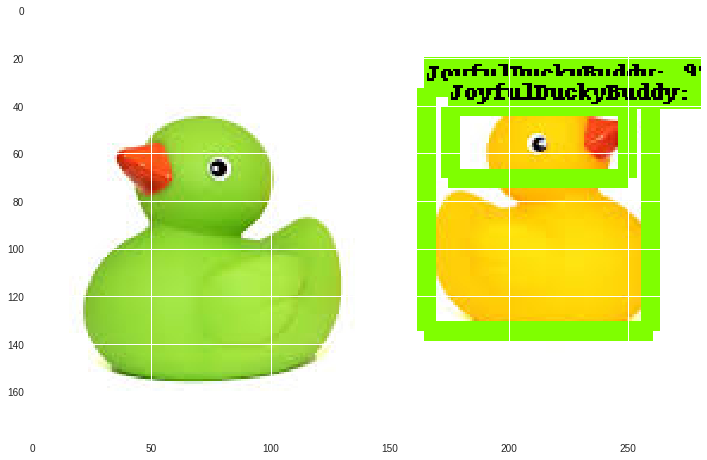

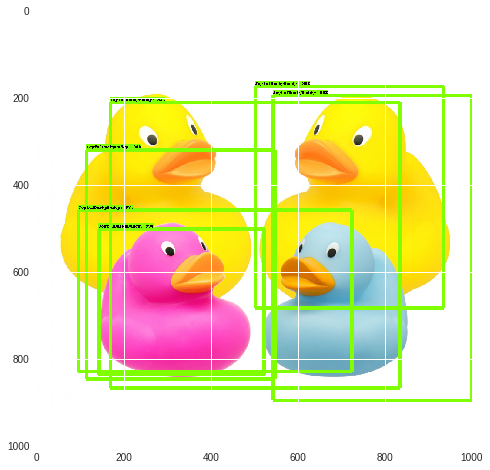

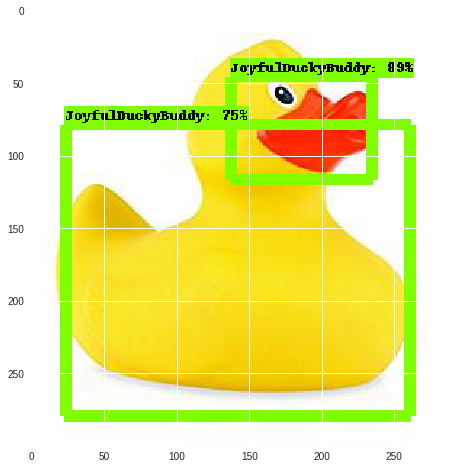

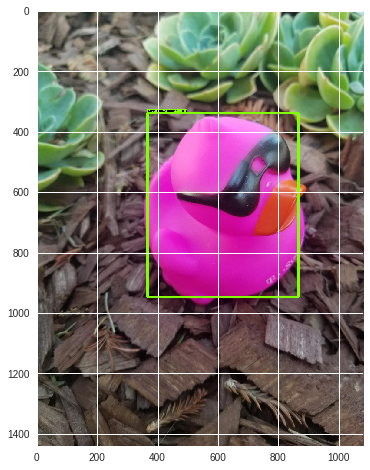

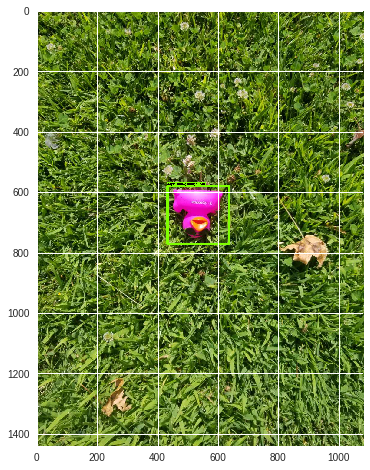

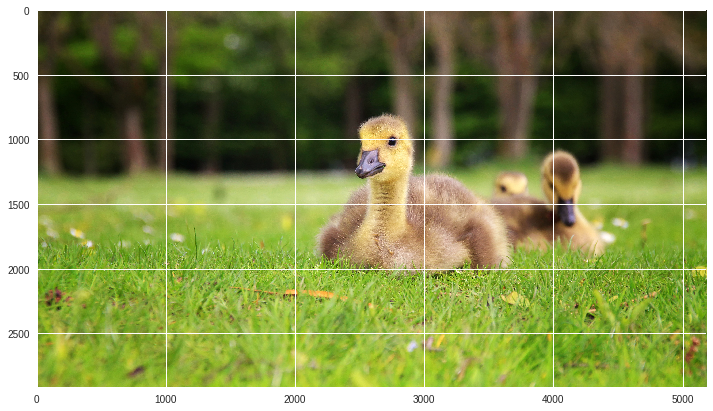

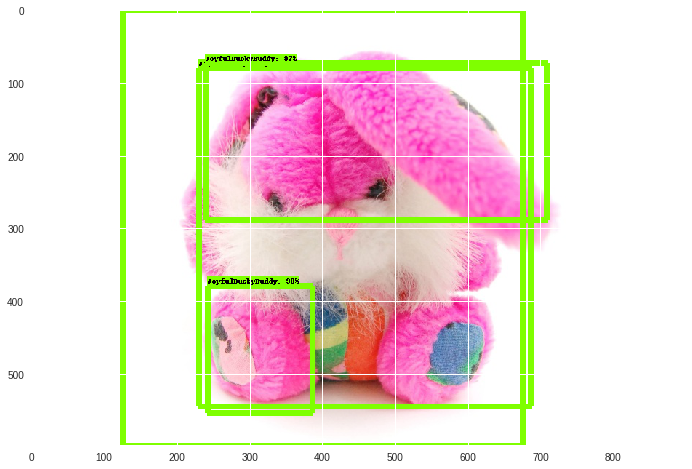

In [46]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

## Conclusion

The detection results showed some  funny false positives, like the last pink rabbit and its left leg :) and false negative since it can't recognize real ducks. This could mainly because I used only about 50 images for model training. (Generally, it would be a good idea to have at least 300 images) So, you should prepare more labeled images for your use cases. 

I hope this tutorial would be helpful to people who wants to start using with Google CoLab GPU. Please feel free to contact me if you have any questions. 


## References

[Tensorflow Object Detection API](tensorflow object detection api) by Google

[*Google Colab Free GPU Tutorial*](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d/)  by Mr. Fuat

[ *Supercharge your Computer Vision models with the TensorFlow Object Detection API*](https://ai.googleblog.com/2017/06/supercharge-your-computer-vision-models.html) by Google AIBlog


